In [3]:
#pip install statsmodels

import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

In [4]:
# ----------------------------------------------------
# Loading datasets WITHOUT interaction terms
# ----------------------------------------------------

X_train = pd.read_excel("X_train.xlsx")
X_test = pd.read_excel("X_test.xlsx")
y_train = pd.read_excel("y_train.xlsx")
y_test = pd.read_excel("y_test.xlsx")

# ----------------------------------------------------
# Loading datasets WITH interaction terms
# ----------------------------------------------------

X_train_inter = pd.read_excel("X_train_inter.xlsx")
X_test_inter = pd.read_excel("X_test_inter.xlsx")
y_train_inter = pd.read_excel("y_train_inter.xlsx")
y_test_inter = pd.read_excel("y_test_inter.xlsx")

print("All datasets have been loaded successfully.")

All datasets have been loaded successfully.


In [6]:
scaler = MinMaxScaler()

scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

scaler.fit(X_train_inter)
X_train_scaled_inter = scaler.transform(X_train_inter)
X_test_scaled_inter = scaler.transform(X_test_inter)

 ************** WARNING: YOU NEED TO NORMALIZE DATASET AND RUN AGAIN ***********************

## Dataset with Interaction Terms

In [7]:
# Add a constant to the independent variables for the intercept term
# OLS requires this to be done manually
X_train_const_inter = sm.add_constant(X_train_scaled_inter)

# Create and fit the OLS model
ols_model = sm.OLS(y_train_inter, X_train_const_inter).fit()

# Print the summary of the model
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    PWP   R-squared:                       0.585
Model:                            OLS   Adj. R-squared:                  0.568
Method:                 Least Squares   F-statistic:                     33.67
Date:                Tue, 02 Sep 2025   Prob (F-statistic):           1.48e-70
Time:                        11:16:40   Log-Likelihood:                 1236.7
No. Observations:                 449   AIC:                            -2435.
Df Residuals:                     430   BIC:                            -2357.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2581      0.082      3.141      0.0

In [8]:
# base code
import numpy as np
import seaborn as sns
from statsmodels.tools.tools import maybe_unwrap_results
from statsmodels.graphics.gofplots import ProbPlot
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from typing import Type

style_talk = 'seaborn-talk'    #refer to plt.style.available

class LinearRegDiagnostic():
    """
    Diagnostic plots to identify potential problems in a linear regression fit.
    Mainly,
        a. non-linearity of data
        b. Correlation of error terms
        c. non-constant variance
        d. outliers
        e. high-leverage points
        f. collinearity

    Authors:
        Prajwal Kafle (p33ajkafle@gmail.com, where 3 = r)
        Does not come with any sort of warranty.
        Please test the code one your end before using.

        Matt Spinelli (m3spinelli@gmail.com, where 3 = r)
        (1) Fixed incorrect annotation of the top most extreme residuals in
            the Residuals vs Fitted and, especially, the Normal Q-Q plots.
        (2) Changed Residuals vs Leverage plot to match closer the y-axis
            range shown in the equivalent plot in the R package ggfortify.
        (3) Added horizontal line at y=0 in Residuals vs Leverage plot to
            match the plots in R package ggfortify and base R.
        (4) Added option for placing a vertical guideline on the Residuals
            vs Leverage plot using the rule of thumb of h = 2p/n to denote
            high leverage (high_leverage_threshold=True).
        (5) Added two more ways to compute the Cook's Distance (D) threshold:
            * 'baseR': D > 1 and D > 0.5 (default)
            * 'convention': D > 4/n
            * 'dof': D > 4 / (n - k - 1)
        (6) Fixed class name to conform to Pascal casing convention
        (7) Fixed Residuals vs Leverage legend to work with loc='best'
    """

    def __init__(self,
                 results: Type[sm.regression.linear_model.RegressionResultsWrapper]) -> None:
        """
        For a linear regression model, generates following diagnostic plots:

        a. residual
        b. qq
        c. scale location and
        d. leverage

        and a table

        e. vif

        Args:
            results (Type[statsmodels.regression.linear_model.RegressionResultsWrapper]):
                must be instance of statsmodels.regression.linear_model object

        Raises:
            TypeError: if instance does not belong to above object

        Example:
        >>> import numpy as np
        >>> import pandas as pd
        >>> import statsmodels.formula.api as smf
        >>> x = np.linspace(-np.pi, np.pi, 100)
        >>> y = 3*x + 8 + np.random.normal(0,1, 100)
        >>> df = pd.DataFrame({'x':x, 'y':y})
        >>> res = smf.ols(formula= "y ~ x", data=df).fit()
        >>> cls = Linear_Reg_Diagnostic(res)
        >>> cls(plot_context="seaborn-v0_8-paper")

        In case you do not need all plots you can also independently make an individual plot/table
        in following ways

        >>> cls = Linear_Reg_Diagnostic(res)
        >>> cls.residual_plot()
        >>> cls.qq_plot()
        >>> cls.scale_location_plot()
        >>> cls.leverage_plot()
        >>> cls.vif_table()
        """

        if isinstance(results, sm.regression.linear_model.RegressionResultsWrapper) is False:
            raise TypeError("result must be instance of statsmodels.regression.linear_model.RegressionResultsWrapper object")

        self.results = maybe_unwrap_results(results)

        self.y_true = self.results.model.endog
        self.y_predict = self.results.fittedvalues
        self.xvar = self.results.model.exog
        self.xvar_names = self.results.model.exog_names

        self.residual = np.array(self.results.resid)
        influence = self.results.get_influence()
        self.residual_norm = influence.resid_studentized_internal
        self.leverage = influence.hat_matrix_diag
        self.cooks_distance = influence.cooks_distance[0]
        self.nparams = len(self.results.params)
        self.nresids = len(self.residual_norm)

    def __call__(self, plot_context='seaborn-v0_8-paper', **kwargs):
        # print(plt.style.available)
        # GH#9157
        if plot_context not in plt.style.available:
            plot_context = 'default'
        with plt.style.context(plot_context):
            fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
            self.residual_plot(ax=ax[0,0])
            self.qq_plot(ax=ax[0,1])
            self.scale_location_plot(ax=ax[1,0])
            self.leverage_plot(
                ax=ax[1,1],
                high_leverage_threshold = kwargs.get('high_leverage_threshold'),
                cooks_threshold = kwargs.get('cooks_threshold'))
            plt.show()

        return self.vif_table(), fig, ax,

    def residual_plot(self, ax=None):
        """
        Residual vs Fitted Plot

        Graphical tool to identify non-linearity.
        (Roughly) Horizontal red line is an indicator that the residual has a linear pattern
        """
        if ax is None:
            fig, ax = plt.subplots()

        sns.residplot(
            x=self.y_predict,
            y=self.residual,
            lowess=True,
            scatter_kws={'alpha': 0.5},
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        residual_abs = np.abs(self.residual)
        abs_resid = np.flip(np.argsort(residual_abs), 0)
        abs_resid_top_3 = abs_resid[:3]
        for i in abs_resid_top_3:
            ax.annotate(
                i,
                xy=(self.y_predict[i], self.residual[i]),
                color='C3')

        ax.set_title('Residuals vs Fitted', fontweight="bold")
        ax.set_xlabel('Fitted values')
        ax.set_ylabel('Residuals')
        return ax

    def qq_plot(self, ax=None):
        """
        Standarized Residual vs Theoretical Quantile plot

        Used to visually check if residuals are normally distributed.
        Points spread along the diagonal line will suggest so.
        """
        if ax is None:
            fig, ax = plt.subplots()

        QQ = ProbPlot(self.residual_norm)
        fig = QQ.qqplot(line='45', alpha=0.5, lw=1, ax=ax)

        # annotations
        abs_norm_resid = np.flip(np.argsort(np.abs(self.residual_norm)), 0)
        abs_norm_resid_top_3 = abs_norm_resid[:3]
        for i, x, y in self.__qq_top_resid(QQ.theoretical_quantiles, abs_norm_resid_top_3):
            ax.annotate(
                i,
                xy=(x, y),
                ha='right',
                color='C3')

        ax.set_title('Normal Q-Q', fontweight="bold")
        ax.set_xlabel('Theoretical Quantiles')
        ax.set_ylabel('Standardized Residuals')
        return ax

    def scale_location_plot(self, ax=None):
        """
        Sqrt(Standarized Residual) vs Fitted values plot

        Used to check homoscedasticity of the residuals.
        Horizontal line will suggest so.
        """
        if ax is None:
            fig, ax = plt.subplots()

        residual_norm_abs_sqrt = np.sqrt(np.abs(self.residual_norm))

        ax.scatter(self.y_predict, residual_norm_abs_sqrt, alpha=0.5);
        sns.regplot(
            x=self.y_predict,
            y=residual_norm_abs_sqrt,
            scatter=False, ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        abs_sq_norm_resid = np.flip(np.argsort(residual_norm_abs_sqrt), 0)
        abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
        for i in abs_sq_norm_resid_top_3:
            ax.annotate(
                i,
                xy=(self.y_predict[i], residual_norm_abs_sqrt[i]),
                color='C3')

        ax.set_title('Scale-Location', fontweight="bold")
        ax.set_xlabel('Fitted values')
        ax.set_ylabel(r'$\sqrt{|\mathrm{Standardized\ Residuals}|}$');
        return ax

    def leverage_plot(self, ax=None, high_leverage_threshold=False, cooks_threshold='baseR'):
        """
        Residual vs Leverage plot

        Points falling outside Cook's distance curves are considered observation that can sway the fit
        aka are influential.
        Good to have none outside the curves.
        """
        if ax is None:
            fig, ax = plt.subplots()

        ax.scatter(
            self.leverage,
            self.residual_norm,
            alpha=0.5);

        sns.regplot(
            x=self.leverage,
            y=self.residual_norm,
            scatter=False,
            ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        leverage_top_3 = np.flip(np.argsort(self.cooks_distance), 0)[:3]
        for i in leverage_top_3:
            ax.annotate(
                i,
                xy=(self.leverage[i], self.residual_norm[i]),
                color = 'C3')

        factors = []
        if cooks_threshold == 'baseR' or cooks_threshold is None:
            factors = [1, 0.5]
        elif cooks_threshold == 'convention':
            factors = [4/self.nresids]
        elif cooks_threshold == 'dof':
            factors = [4/ (self.nresids - self.nparams)]
        else:
            raise ValueError("threshold_method must be one of the following: 'convention', 'dof', or 'baseR' (default)")
        for i, factor in enumerate(factors):
            label = "Cook's distance" if i == 0 else None
            xtemp, ytemp = self.__cooks_dist_line(factor)
            ax.plot(xtemp, ytemp, label=label, lw=1.25, ls='--', color='red')
            ax.plot(xtemp, np.negative(ytemp), lw=1.25, ls='--', color='red')

        if high_leverage_threshold:
            high_leverage = 2 * self.nparams / self.nresids
            if max(self.leverage) > high_leverage:
                ax.axvline(high_leverage, label='High leverage', ls='-.', color='purple', lw=1)

        ax.axhline(0, ls='dotted', color='black', lw=1.25)
        ax.set_xlim(0, max(self.leverage)+0.01)
        ax.set_ylim(min(self.residual_norm)-0.1, max(self.residual_norm)+0.1)
        ax.set_title('Residuals vs Leverage', fontweight="bold")
        ax.set_xlabel('Leverage')
        ax.set_ylabel('Standardized Residuals')
        plt.legend(loc='best')
        return ax

    def vif_table(self):
        """
        VIF table

        VIF, the variance inflation factor, is a measure of multicollinearity.
        VIF > 5 for a variable indicates that it is highly collinear with the
        other input variables.
        """
        vif_df = pd.DataFrame()
        vif_df["Features"] = self.xvar_names
        vif_df["VIF Factor"] = [variance_inflation_factor(self.xvar, i) for i in range(self.xvar.shape[1])]

        return (vif_df
                .sort_values("VIF Factor")
                .round(2))


    def __cooks_dist_line(self, factor):
        """
        Helper function for plotting Cook's distance curves
        """
        p = self.nparams
        formula = lambda x: np.sqrt((factor * p * (1 - x)) / x)
        x = np.linspace(0.001, max(self.leverage), 50)
        y = formula(x)
        return x, y


    def __qq_top_resid(self, quantiles, top_residual_indices):
        """
        Helper generator function yielding the index and coordinates
        """
        offset = 0
        quant_index = 0
        previous_is_negative = None
        for resid_index in top_residual_indices:
            y = self.residual_norm[resid_index]
            is_negative = y < 0
            if previous_is_negative == None or previous_is_negative == is_negative:
                offset += 1
            else:
                quant_index -= offset
            x = quantiles[quant_index] if is_negative else np.flip(quantiles, 0)[quant_index]
            quant_index += 1
            previous_is_negative = is_negative
            yield resid_index, x, y

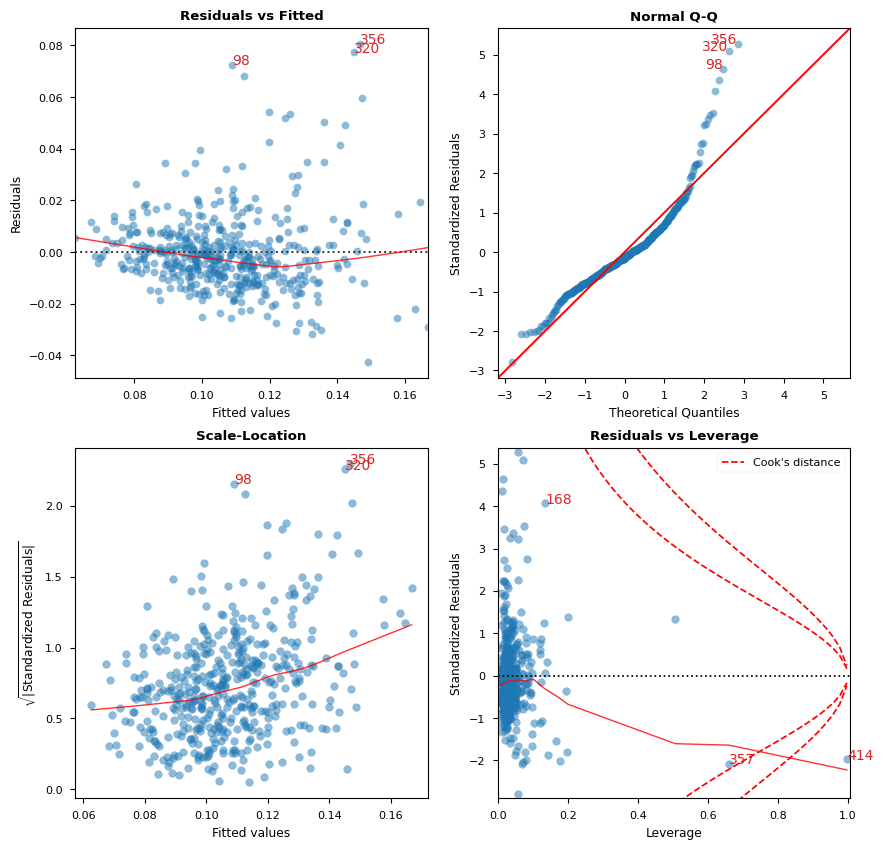

   Features  VIF Factor
3        x3        1.03
9        x9        1.45
10      x10        1.49
12      x12        1.95
6        x6        2.52
5        x5        2.81
7        x7        3.11
11      x11        5.26
13      x13       10.53
18      x18      217.46
16      x16      563.51
14      x14      792.97
1        x1     1667.62
2        x2     1796.86
4        x4     2278.96
17      x17     2800.55
8        x8     3071.70
15      x15     3462.51
0     const    12245.64


In [9]:
cls = LinearRegDiagnostic(ols_model)
vif, fig, ax = cls()
print(vif)

# fig.savefig("my_plot1.png") #comment out this section if you made changes to the plot

**Residuals vs. Fitted Plot** - Linearity and Homoscedaticity: The plot are not randomly scattered around the horizontal dashed line which can be seen in the red line (the red line is a smoothed avergae of the residuals) which is mimicing pattern of the errors. This suggest that the data is most likely not linear. In addition, the residuals spread out around at the end of the dashed line suggesting some form of heterorscadacity (the variance of the errors are not constant). The way the error fan out along the dash line, it suggests that large errors could be influencing the model predictions. 

**Normal Q-Q Plot (Quantile-Quantile Plot)** - Normality: The plots follow the red diagonal line but suddenly deviate at the upper and lower ends of the line suggesting that the residuals are not perfectly normal, an important assumption of linear regression. One can say its not a near perfect normally distributed errorr, because it meets the assumptions except when it comes to the end of the diagonal line.

**Scale-Location Plot** - Homoscedaticity: This plot solidifies the trends seen in the previous plots. For this plot, the points should be distributed along the horizontal line with no curve. The reverse is the case here. The points show an upward sloping curve as well as the red line.

**Residuals vs. Leverage Plot** - Influential Outliers: Points outside or close to the red lines (cook distance) are considered the most influential outliers. Linear regression is very sensitize to outliers. 168, 357, and 414 have high leverage or large residuals. Point 168 has a high residual but moderate leverage, while points 357 and 414 have high leverage and are close to Cook's distance boundary.

**Variance Inflation Factor**
This shows that there is high collinearity going on within the predictors as excepted. Using an interaction term introduced multicollinerity into the mix. A VIF value greater than 5-10 is generally considered problematic. In this case sand_x_silt, silt_x_active_carbon, and sand_x_active_carbon are candidates for removal.


**Conclusion**
1. linearity assumption not met. Heteroscadacity present.
2. Normality assumption violated. Prediction may be infleuenced by large errors.
3. Heterescedasicity; confirms violation of constant varianc eof errors as seen in the Residuals vs. Fitted Plot.
4. Presense of influential outlier. Regression is sensitive to outliers.
5. Model is suffering from severe multicollinearity

## Dataset without Interaction Terms

In [10]:
# X_train.head(3)
# X_train_inter.head(3)

scaler = MinMaxScaler()

scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)



In [11]:
# Add a constant to the independent variables for the intercept term
# OLS requires this to be done manually
X_train_const = sm.add_constant(X_train_scaled)

# Create and fit the OLS model
ols_model = sm.OLS(y_train, X_train_const).fit()

# Print the summary of the model
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    PWP   R-squared:                       0.579
Model:                            OLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                     49.98
Date:                Tue, 02 Sep 2025   Prob (F-statistic):           3.48e-74
Time:                        11:19:46   Log-Likelihood:                 1233.6
No. Observations:                 449   AIC:                            -2441.
Df Residuals:                     436   BIC:                            -2388.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1725      0.017      9.981      0.0

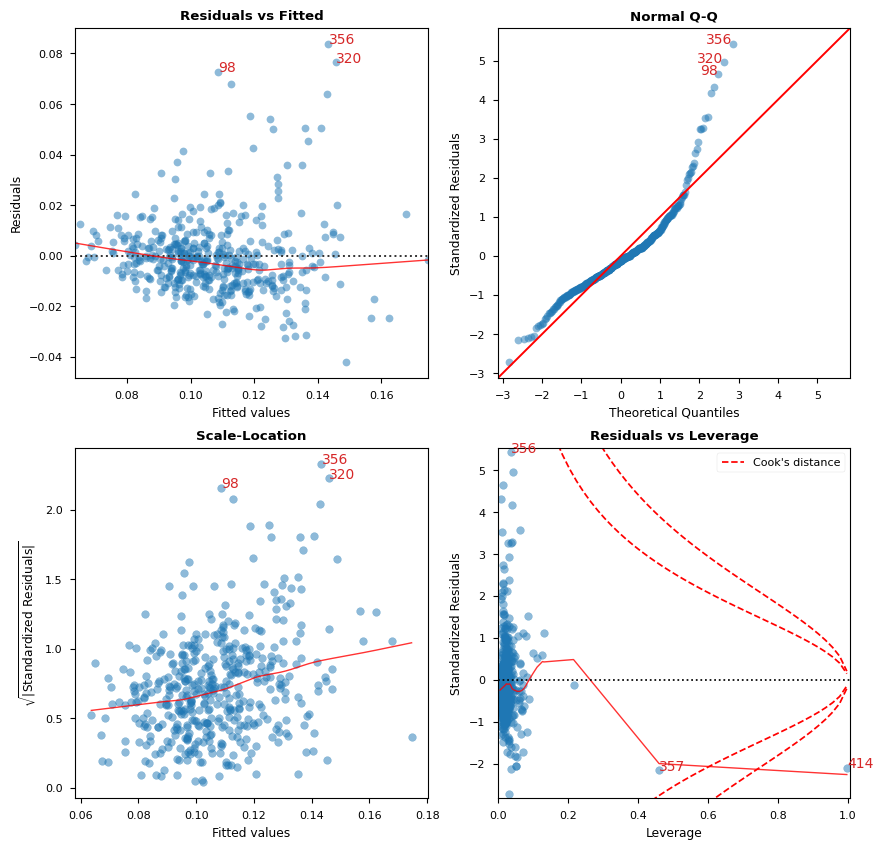

   Features  VIF Factor
3        x3        1.02
9        x9        1.42
10      x10        1.44
8        x8        1.55
12      x12        1.91
6        x6        2.41
5        x5        2.73
7        x7        2.97
4        x4        3.62
11      x11        4.92
2        x2        7.76
1        x1        8.59
0     const      541.40


In [12]:
cls = LinearRegDiagnostic(ols_model)
vif, fig, ax = cls()
print(vif)

Although the removal of the interaction terms address the multicollinearity violation, it does not address the violation of other assumptions like linearity, heterscadasity and presence of outliers. Its best to explore other non-linear models using the dataset without the interaction terms.

# **conclusion**

With Interaction Terms: R<sup>2</sup> =0.585 -> 18 predictors (17 features + constant)

Without Interaction Terms: R<sup>2</sup> =0.579 -> 12 predictors (11 features + constant)

Based on the model performance across both models, the model with interaction terms has a higher proportion of the variance in PWP explained by the variables included in the model. But, when we look at the adjusted R squared the values are not that much different. 

Also, the mdoels with the interaction terms have very high p-values suggesting that the added variables has no statistical significance. There is also a conclusion to draw from the condition number. Since this is a multiple linear regression, a large condition indicates a strong case of multicollinearity in play as seen in the diagnostics plots. Even though the VIF is less than 10 for most of the model without the interaction term, the condition number is still large indicating that both datasets have issue with multicollinearity. 

The plausible solution is to explore Multivariate Adaptive Regression Splines (MARS) and Gene Expression Programming (GEP). These models are specifically designed to handle and discover non-linear relationships in data, which a simple linear model is failing to capture.

Note: condition number isn't something to worry about when dealing with simple linear regression. 

https://stats.stackexchange.com/questions/243000/cause-of-a-high-condition-number-in-a-python-statsmodels-regression